In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from dataloader import PreprocessedDataset, rsplit

import dsocc
import loss
import STTR_Loader

from loss import geo_scal_loss, sem_scal_loss, CE_ssc_loss, one_hot_encoding

import warnings
warnings.filterwarnings('ignore')



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

#device = 'cpu'
print(device)


cuda:0


In [15]:
def voxel_to_coordinates(voxel_data, voxel_size=0.01, threshold = 0):
    xx, yy, zz = voxel_data.shape
    x_coords = []
    y_coords = []
    z_coords = []
    tags = []
    for x in range(xx):
        for y in range(yy):
            for z in range(zz):
                tag = voxel_data[x, y, z]
                if tag > threshold:
                    x_coords.append(x * voxel_size)
                    y_coords.append(y * voxel_size)
                    z_coords.append(z * voxel_size)
                    tags.append(tag)

    return np.array(x_coords), np.array(y_coords), np.array(z_coords), np.array(tags)



def visualize_labeled_array3d(voxel_data, num_classes=8, size = None, marker = None):
    class_names = ['empty',
     'vehicles',
     'building',
     'road',
     'sidewalk',
     'vegetation',
     'others',
     'unknown']
    voxel_data = voxel_data.astype(np.uint16)
    x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0])
    
    color_scale = bqplot.scales.ColorScale(min=0, max=num_classes, colors=["#f00", "#00f", "#000000", "#808080", "#0f0", "#DC143C", "#800080"])
    
    fig = ipv.figure()
    unique_tags = np.unique(tags)

    for tag in unique_tags:
        mask = tags == tag
        x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
        
        ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.1, description="len({})={}".format(str(class_names[tag]),x_filtered.shape[0]))
    ipv.xyzlabel('y','x','z')
    ipv.view(0, -30, distance=1.5)
    ipv.show()



def plot_tensor2d(img_tensor):
    tensor = img_tensor.permute(1, 2, 0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    plt.imshow(tensor)

def plot_voxel3d(voxel_tensor, shape=(64, 64, 8), size=2):
    visualize_labeled_array3d((voxel_tensor.view(shape).float()).detach().cpu().numpy(), size=size, marker='box')

In [16]:
batch_size = 3

In [17]:
train_set = PreprocessedDataset('../preprocessed_data/preprocessed_999_1.h5')
len(train_set)

999

In [18]:
test_set = PreprocessedDataset('../preprocessed_data/preprocessed_500_10.h5')
len(test_set)

500

In [19]:
test_set.class_names

['empty',
 'vehicles',
 'building',
 'road',
 'sidewalk',
 'vegetation',
 'others',
 'unknown']

In [20]:
from dsocc import DepthSegLift_OCC, instantiate_dsocc, inference

num_classes = train_set.num_classes
sttr_weight_path = '/workspace/PretrainedWeights/kitti_finetuned_model.pth.tar'

model = instantiate_dsocc(sttr_weight_path, num_classes, device)

Pre-trained model successfully loaded.
[STTR]Number of parameters (in millions): 2.513811 M
[SegFormer]Number of parameters (in millions): 84.607955 M
[DSOCC]Number of parameters (in millions): 137.068223 M
[DSOCC]Number of trainable parameters (in millions): 49.946457 M


In [121]:
model.load_state_dict(torch.load('../Experiments/checkpoints/dsocc_7_39and11.pth', map_location=device))

<All keys matched successfully>

In [122]:
left_img, right_img, gt = test_set.get_batched_data(random.randint(0, len(test_set)-1))

pred = inference(model, left_img, right_img, gt, device)

In [123]:
pred.shape

torch.Size([1, 64, 64, 8])

In [124]:
gt.shape

torch.Size([1, 64, 64, 8])

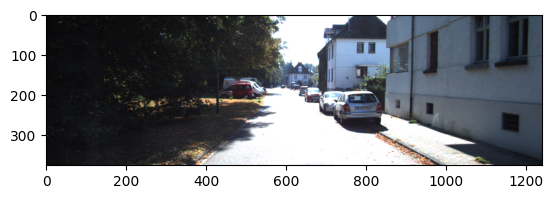

In [125]:
plot_tensor2d(left_img.squeeze(0))

In [126]:
plot_voxel3d(pred, shape=(64, 64, 8), size=2)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [127]:
plot_voxel3d(gt, shape=(64, 64, 8), size=2)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [92]:
left_img, right_img, gt = test_set.get_batched_data(random.randint(0, len(test_set)-1))

pred = inference(model, left_img, right_img, gt, device)

In [93]:
plot_voxel3d(pred, shape=(64, 64, 8), size=2)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [85]:
plot_voxel3d(gt, shape=(64, 64, 8), size=2)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [28]:
# def save_pred(voxel_data, num_classes, fname, size = None, marker = None):
#     class_names = ['empty',
#      'vehicles',
#      'building',
#      'road',
#      'sidewalk',
#      'vegetation',
#      'others',
#      'unknown']
#     voxel_data = voxel_data.astype(np.uint16)
#     x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0])
    
#     color_scale = bqplot.scales.ColorScale(min=0, max=num_classes, colors=["#f00", "#00f", "#000000", "#808080", "#0f0", "#DC143C", "#800080"])
    
#     fig = ipv.figure()
#     unique_tags = np.unique(tags)

#     for tag in unique_tags:
#         mask = tags == tag
#         x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
        
#         ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.1, description="len({})={}".format(str(class_names[tag]),x_filtered.shape[0]))
#     ipv.xyzlabel('y','x','z')
#     ipv.view(0, -30, distance=1.5)
#     ipv.savefig(fname+'.png')
#     #ipv.show()

# def save_voxel3d(voxel_tensor, fpath, shape=(64, 64, 8), size=2):
#     visualize_labeled_array3d((voxel_tensor.view(shape).float()).detach().cpu().numpy(), fname, size=size, marker='box')